In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/codeopdapt4/HomeCredit_columns_description.csv
/kaggle/input/codeopdapt4/samplesubmission.csv
/kaggle/input/codeopdapt4/train.csv
/kaggle/input/codeopdapt4/test.csv


# 1. Introduction

In consumer finance, credit decisions are often made at the application stage, where only limited information about the applicant is available.  
The objective of this project is to analyze loan default risk using application-level data and to build a logistic regression model that may reflect real-world loan management practices.

This project focuses on:
- Understanding key applicant characteristics related to default risk
- Constructing proxy variables for repayment burden and credit behavior
- Building a logistic regression model
- Interpreting results from a business and risk management perspective

Dataset source: Kaggle – CodeOp - DAPT4 - Home Credit Default Risk https://www.kaggle.com/competitions/codeopdapt4/data


# 2. Data Preparation

##  2.1 Inputting the data

In [106]:
import pandas as pd
df_file_path = "/kaggle/input/codeopdapt4/train.csv"
data = pd.read_csv(df_file_path)
data.head()

,SK_ID_CURR,default,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,150293,0,Cash loans,M,Y,Y,0,202500.0,495000.0,13743.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,102579,0,Cash loans,F,N,N,0,112500.0,490495.5,26014.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,106708,0,Cash loans,M,N,Y,0,180000.0,450000.0,20979.0,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,1.0
3,359769,0,Cash loans,F,N,Y,1,202500.0,636138.0,23499.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
4,444585,0,Revolving loans,F,N,Y,0,49500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


##  2.2 Definition of the target variable

By reading "HomeCredit_columns_description.csv", we can know that the target variable `default` is defined as:
- `1`: The client experienced serious payment difficulties (late payment exceeding a predefined threshold during early installments).
- `0`: All other cases.

##  2.3 Feature selection 

Although the dataset contains 122 columns, not all are required for this analysis. We can roughly classify these columns to 6 feature categories by the relationship with the target variable and the availability of the the application stage:
- Demographics
- Income and Employment stability
- Loan characteristics
- Loan burden indicators
- External credit risk proxies
- Behavioral and inquiry signals
- others


In [107]:
a = data["EXT_SOURCE_1"].isnull().sum()
b = data["EXT_SOURCE_2"].isnull().sum()
c = data["EXT_SOURCE_3"].isnull().sum()
print("NAN_EXT_SOURCE_1:", a," ","NAN_EXT_SOURCE_2:", b," ","NAN_EXT_SOURCE_3:", c)

NAN_EXT_SOURCE_1: 5072   NAN_EXT_SOURCE_2: 15   NAN_EXT_SOURCE_3: 1816


Regarding to the external credit risk proxies, we have three columns and they are "EXT_SOURCE_1", "EXT_SOURCE_2", and "EXT_SOURCE_3". However, the NAN values in "EXT_SOURCE_2" is only 15, which is fairly less than "EXT_SOURCE_1" and "EXT_SOURCE_3", we just use "EXT_SOURCE_2" as external credit risk proxy.

In [108]:
selected_features = [
    "default",
    "NAME_CONTRACT_TYPE",        # Loan characteristics
    "CODE_GENDER",               # Demographics
    "AMT_INCOME_TOTAL",          # Income and Employment stability
    "AMT_CREDIT",                # Loan characteristics
    "AMT_ANNUITY",               # Loan characteristics
    "DAYS_BIRTH",                # Demographics
    "DAYS_EMPLOYED",             # Income and Employment stability
    "EXT_SOURCE_2",              # External credit risk proxy
    "AMT_REQ_CREDIT_BUREAU_MON", # Behavioral and inquiry signals
]
df = data[selected_features].copy()
df.head()

,default,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_MON
0,0,Cash loans,M,202500.0,495000.0,13743.0,-18128,-1584,0.501166,0.0
1,0,Cash loans,F,112500.0,490495.5,26014.5,-22431,365243,0.617986,NaN
2,0,Cash loans,M,180000.0,450000.0,20979.0,-12435,-1648,0.755620,1.0
3,0,Cash loans,F,202500.0,636138.0,23499.0,-18454,-2163,0.445139,0.0
4,0,Revolving loans,F,49500.0,270000.0,13500.0,-20941,365243,0.727265,0.0


# 3. Feature Engineering 

## 3.1 Dealing with abnormal values

In [109]:
df[df["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"]

1       365243
4       365243
16      365243
20      365243
31      365243
         ...  
8972    365243
8982    365243
8992    365243
8998    365243
8999    365243
Name: DAYS_EMPLOYED, Length: 1644, dtype: int64

The values of "DAYS_EMPLOYED" shuld be minus, but it contains an abnormal value of 365243, which does not represent a valid employment duration and should be dealed.

In [110]:
import numpy as np
df["DAYS_BIRTH"] = (-df["DAYS_BIRTH"]) / 365
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace("365243", np.nan) / (-365)

##   3.2 Adding the ANNUITY_INCOME_RATIO

Add the column of "ANNUITY_INCOME_RATIO" as Loan burden indicator by dividing the values of "AMT_ANNUITY" by the values of "AMT_INCOME_TOTAL". This ratio approximates the applicant’s repayment burden and serves as a proxy for debt stress at the application stage.

In [111]:
df["ANNUITY_INCOME_RATIO"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"] 

##  3.3 Categorical encoding

In [112]:
df = pd.get_dummies(df, columns=["NAME_CONTRACT_TYPE", "CODE_GENDER"], drop_first=True)

##  3.4 Dealing with missing values

In [113]:
df.isnull().mean().sort_values(ascending=False)

AMT_REQ_CREDIT_BUREAU_MON             0.140111
EXT_SOURCE_2                          0.001667
default                               0.000000
AMT_CREDIT                            0.000000
AMT_INCOME_TOTAL                      0.000000
DAYS_BIRTH                            0.000000
AMT_ANNUITY                           0.000000
DAYS_EMPLOYED                         0.000000
ANNUITY_INCOME_RATIO                  0.000000
NAME_CONTRACT_TYPE_Revolving loans    0.000000
CODE_GENDER_M                         0.000000
dtype: float64

In [114]:
df["AMT_REQ_CREDIT_BUREAU_MON"] = df["AMT_REQ_CREDIT_BUREAU_MON"].fillna(df["AMT_REQ_CREDIT_BUREAU_MON"].median())
df["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].fillna(df["EXT_SOURCE_2"].median())

In [115]:
df.isnull().mean().sort_values(ascending=False)

default                               0.0
AMT_INCOME_TOTAL                      0.0
AMT_CREDIT                            0.0
AMT_ANNUITY                           0.0
DAYS_BIRTH                            0.0
DAYS_EMPLOYED                         0.0
EXT_SOURCE_2                          0.0
AMT_REQ_CREDIT_BUREAU_MON             0.0
ANNUITY_INCOME_RATIO                  0.0
NAME_CONTRACT_TYPE_Revolving loans    0.0
CODE_GENDER_M                         0.0
dtype: float64

# 4. Modeling 

##  4.1 Train_Test_Split

In [116]:
from sklearn.model_selection import train_test_split
X = df.drop(columns="default")
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

##  4.2 Logistic regression model

In [117]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

##  4.3 Model evaluation

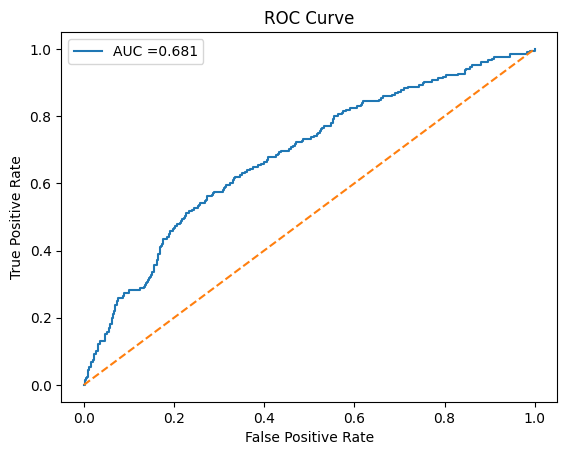

In [118]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, label=f"AUC ={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

The logistic regression model achieves an AUC of **0.681**, indicating **moderate discriminatory power** in distinguishing higher- and lower-risk applicants based solely on application-stage information, particularly in the low false positive rate (FPR) region. This makes the model suitable for **conservative early-stage screening**.

##  4.4 Feature importance analysis

In [119]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
coef_df

,Feature,Coefficient
9,CODE_GENDER_M,4.412175e-01
6,AMT_REQ_CREDIT_BUREAU_MON,3.525546e-02
4,DAYS_EMPLOYED,3.000955e-04
2,AMT_ANNUITY,1.005789e-05
1,AMT_CREDIT,-2.682213e-07
0,AMT_INCOME_TOTAL,-9.976984e-07
3,DAYS_BIRTH,-9.879392e-03
7,ANNUITY_INCOME_RATIO,-8.507903e-02
8,NAME_CONTRACT_TYPE_Revolving loans,-9.231606e-01
5,EXT_SOURCE_2,-1.944453e+00


**EXT_SOURCE_2** exhibits a strong negative coefficient, indicating that higher external credit scores are associated with a lower probability of default. This aligns with the role of third-party credit bureau information as a key risk signal at the application stage. And **Contract type (Revolving loans)** is associated with lower default risk in this specification, conditional on other application-level controls.However, **Income- and repayment-related variables** (e.g., AMT_INCOME_TOTAL, AMT_ANNUITY, and their ratio) display smaller coefficients and mixed signs, reflecting multicollinearity.

Overall, the coefficient analysis highlights some economically interpretable risk signals, but parts of them are counterintuitive due to differences in feature scales and correlations among financial variables. It means that we should reinforce the importance of evaluating the model primarily through **ranking performance and decision-level behavior** rather than point estimates of individual coefficients.




##  4.5 Decision thresholds and risk trade-offs

Rather than fixing a single decision threshold, this section examines multiple operating points under different false positive rate constraints to illustrate the trade-offs involved in application-stage credit decisions.

In [120]:
# FPR = 15%
X = 0.15  
idx_candidates = np.where(fpr <= X)[0]
best_idx = idx_candidates[np.argmax(tpr[idx_candidates])]
best_threshold = thresholds[best_idx]
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]
y_pred = (y_test_pred_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) else 0.0
specificity = tn / (tn + fp) if (tn + fp) else 0.0  
print(f"Constraint: FPR <= {X:.2f}")
print(f"Chosen threshold: {best_threshold:.4f}")
print(f"Achieved FPR: {best_fpr:.4f}")
print(f"Achieved TPR: {best_tpr:.4f}")
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision: {precision:.4f}, Specificity: {specificity:.4f}")

Constraint: FPR <= 0.15
Chosen threshold: 0.1116
Achieved FPR: 0.1483
Achieved TPR: 0.3268
Confusion matrix: TN=2125, FP=370, FN=138, TP=67
Precision: 0.1533, Specificity: 0.8517


In [121]:
# FPR = 10%
X = 0.10  
idx_candidates = np.where(fpr <= X)[0]
best_idx = idx_candidates[np.argmax(tpr[idx_candidates])]
best_threshold = thresholds[best_idx]
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]
y_pred = (y_test_pred_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) else 0.0
specificity = tn / (tn + fp) if (tn + fp) else 0.0  
print(f"Constraint: FPR <= {X:.2f}")
print(f"Chosen threshold: {best_threshold:.4f}")
print(f"Achieved FPR: {best_fpr:.4f}")
print(f"Achieved TPR: {best_tpr:.4f}")
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision: {precision:.4f}, Specificity: {specificity:.4f}")

Constraint: FPR <= 0.10
Chosen threshold: 0.1260
Achieved FPR: 0.0998
Achieved TPR: 0.2780
Confusion matrix: TN=2246, FP=249, FN=148, TP=57
Precision: 0.1863, Specificity: 0.9002


In [122]:
# FPR = 5%
X = 0.05  
idx_candidates = np.where(fpr <= X)[0]
best_idx = idx_candidates[np.argmax(tpr[idx_candidates])]
best_threshold = thresholds[best_idx]
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]
y_pred = (y_test_pred_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) else 0.0
specificity = tn / (tn + fp) if (tn + fp) else 0.0  
print(f"Constraint: FPR <= {X:.2f}")
print(f"Chosen threshold: {best_threshold:.4f}")
print(f"Achieved FPR: {best_fpr:.4f}")
print(f"Achieved TPR: {best_tpr:.4f}")
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision: {precision:.4f}, Specificity: {specificity:.4f}")

Constraint: FPR <= 0.05
Chosen threshold: 0.1550
Achieved FPR: 0.0477
Achieved TPR: 0.1512
Confusion matrix: TN=2376, FP=119, FN=174, TP=31
Precision: 0.2067, Specificity: 0.9523


Under stricter FPR constraints, the model maintains high specificity but captures only a limited fraction of defaulters. Relaxing the constraint improves TPR at the cost of a rapidly increasing number of false rejections, highlighting the inherent trade-off faced in application-stage credit decisions.

What's more, under a 10% FPR constraint, the model captures approximately 28% of defaulters, suggesting its suitability as a conservative screening tool rather than a standalone approval mechanism.

# 5. Prediction

##  5.1 Inputting the data

In [123]:
pre_file_path = "/kaggle/input/codeopdapt4/test.csv"
pre= pd.read_csv(pre_file_path)
selected_features = [
    "NAME_CONTRACT_TYPE",        # Loan characteristics
    "CODE_GENDER",               # Demographics
    "AMT_INCOME_TOTAL",          # Income and Employment stability
    "AMT_CREDIT",                # Loan characteristics
    "AMT_ANNUITY",               # Loan characteristics
    "DAYS_BIRTH",                # Demographics
    "DAYS_EMPLOYED",             # Income and Employment stability
    "EXT_SOURCE_2",              # External credit risk proxy
    "AMT_REQ_CREDIT_BUREAU_MON", # Behavioral and inquiry signals
]
pr = pre[selected_features].copy()

##  5.2 Preparing the data

In [124]:
pr["DAYS_BIRTH"] = (-pr["DAYS_BIRTH"]) / 365
pr["DAYS_EMPLOYED"] = pr["DAYS_EMPLOYED"].replace("365243", np.nan) / (-365)
pr["AMT_REQ_CREDIT_BUREAU_MON"] = pr["AMT_REQ_CREDIT_BUREAU_MON"].fillna(pr["AMT_REQ_CREDIT_BUREAU_MON"].median())
pr["EXT_SOURCE_2"] = pr["EXT_SOURCE_2"].fillna(pr["EXT_SOURCE_2"].median())
pr["ANNUITY_INCOME_RATIO"] = pr["AMT_ANNUITY"] / pr["AMT_INCOME_TOTAL"] 
pr = pd.get_dummies(pr, columns=["NAME_CONTRACT_TYPE", "CODE_GENDER"], drop_first=True)

## 5.3 Outputting the data

In [125]:
X = pr
y_pred_proba = model.predict_proba(X)[:, 1]
submission = pd.DataFrame({
    "SK_ID_CURR": pre["SK_ID_CURR"],
    "default": y_pred_proba
})
submission.to_csv("submission.csv", index=False)

# 6. Business Insights and Implications

In kinds of variables, external credit information (e.g., EXT_SOURCE_2) plays a central role in distinguishing higher- and lower-risk applicants, highlighting the importance of third-party credit bureau data when historical repayment records are not totally available.

# 7. Limitations and Future Work

##  7.1 Limitations of data and model

- Limited Feature Scope
The model relies solely on application-stage variables and excludes post-application behavioral data (e.g., payment history, delinquency trajectories), which are known to be highly predictive of default.

- Linear Specification
Logistic regression assumes linear relationships between variables and default, which may not fully capture complex nonlinear patterns or interaction effects that often characterize credit risk dynamics.

- Moderate Predictive Power
With an AUC of approximately **0.68**, the model demonstrates moderate but limited discriminatory power. While sufficient for risk ranking and conservative screening, this level of performance constrains its use as a standalone decision engine and highlights the need for complementary models or additional data sources in operational settings.

##  7.2 Directions for future improvement

- Incorporating additional data sources, such as previous loan performance or transactional behavior, to improve discriminatory power.

- Exploring nonlinear or tree-based models (e.g., Random Forests) to capture interaction effects and threshold behavior.

- Conducting out-of-time validation to assess model stability across different economic conditions.